In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install tensorflow_addons

In [17]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

 ## Data Loading and Preprocessing

In [56]:
# Define dataset paths
train_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/train'
val_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/val'
test_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/test'

# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
SEED = 42

# Create datasets using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=True,  # to introduce randomness in each epoch and improve training.
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    #class_names=classes,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    #validation_split=0.2,
    #subset='test',
    seed=1337
)

def preprocess_image(image, label):
    image = tfa.image.equalize(image)
    return image, label


train_dataset = train_ds.map(preprocess_image).shuffle(buffer_size=200)
val_dataset = val_ds.map(preprocess_image)


train_dataset = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.


## Learning Rate Scheduler

List of learning rate:  [6.25e-06, 1.25e-05, 2.5e-05, 5e-05, 0.0001, 9.938441702975689e-05, 9.755282581475769e-05, 9.45503262094184e-05, 9.045084971874738e-05, 8.535533905932738e-05, 7.938926261462366e-05, 7.269952498697734e-05, 6.545084971874738e-05, 5.782172325201155e-05, 5e-05, 4.217827674798846e-05, 3.4549150281252636e-05, 2.7300475013022663e-05, 2.061073738537635e-05, 1.4644660940672627e-05]


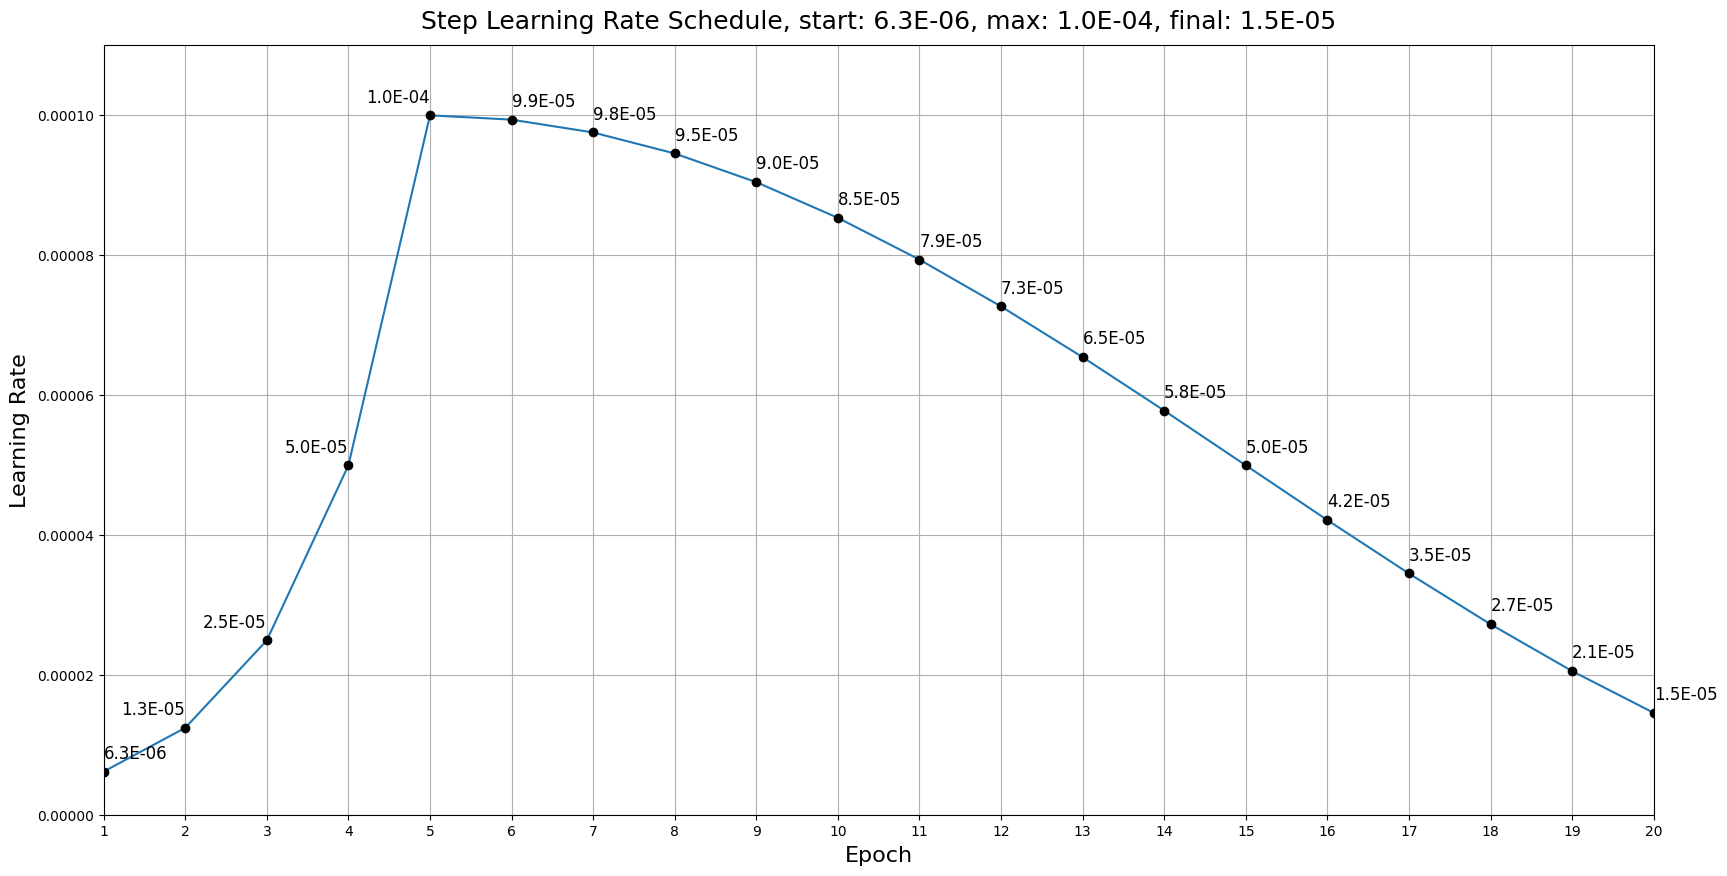

In [57]:
# Import libraries
import math
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_EPOCHS = 20
warm_up_ep  = 4
num_cycles  = 0.4
lr_max = 1e-4

def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        # exponiancial warmup
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    plt.ylim([0, max(lr_schedule) * 1.1])

    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()




LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
print('List of learning rate: ', LR_SCHEDULE)

plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



## Callbacks

In [77]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_before_augmentation_resnet101.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),  # Stop training if no improvement after 7 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: lr_list[step], verbose=0),
    tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]



## Model Definition and Compile

In [78]:

#base_model = tf.keras.applications.efficientnet.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model = tf.keras.applications.resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
#base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [79]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
)


history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=val_dataset,
    callbacks=[my_callbacks],
)

Epoch 1/20
289/289 [==============================] - ETA: 0s - loss: 25.8506 - accuracy: 0.2459

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 96s 122ms/step - loss: 25.8506 - accuracy: 0.2459 - val_loss: 25.4386 - val_accuracy: 0.3971 - lr: 6.2500e-06
Epoch 2/20
289/289 [==============================] - 37s 128ms/step - loss: 24.9462 - accuracy: 0.3475 - val_loss: 24.3597 - val_accuracy: 0.4140 - lr: 1.2500e-05
Epoch 3/20
289/289 [==============================] - 38s 130ms/step - loss: 23.3021 - accuracy: 0.4200 - val_loss: 22.1691 - val_accuracy: 0.4855 - lr: 2.5000e-05
Epoch 4/20
289/289 [==============================] - 38s 130ms/step - loss: 20.3199 - accuracy: 0.5009 - val_loss: 18.5147 - val_accuracy: 0.5315 - lr: 5.0000e-05
Epoch 5/20
289/289 [==============================] - 39s 134ms/step - loss: 15.3868 - accuracy: 0.5831 - val_loss: 12.6902 - val_accuracy: 0.5678 - lr: 1.0000e-04
Epoch 6/20
289/289 [==============================] - 37s 129ms/step - loss: 10.3888 - accuracy: 0.6693 - val_loss: 8.7037 - val_accuracy: 0.5702 - lr: 9.9384e-05
Epoch 7/20
289/289 [========

## Layers counts

In [80]:
# Create a dictionary to store layer counts
layer_counts = {}

# Iterate through the model's layers
for layer in model.layers:
    layer_type = type(layer).__name__
    if layer_type in layer_counts:
        layer_counts[layer_type] += 1
    else:
        layer_counts[layer_type] = 1

# Print the total layer counts for each layer type
for layer_type, count in layer_counts.items():
    print(f"Layer type '{layer_type}' is applied {count} times.")


Layer type 'InputLayer' is applied 1 times.
Layer type 'ZeroPadding2D' is applied 2 times.
Layer type 'Conv2D' is applied 104 times.
Layer type 'BatchNormalization' is applied 105 times.
Layer type 'Activation' is applied 100 times.
Layer type 'MaxPooling2D' is applied 1 times.
Layer type 'Add' is applied 33 times.
Layer type 'GlobalAveragePooling2D' is applied 1 times.
Layer type 'Dense' is applied 4 times.
Layer type 'Dropout' is applied 3 times.


In [81]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print('Test accuracy:', test_accuracy)

83/83 [==============================] - 3s 33ms/step - loss: 1.6709 - accuracy: 0.6425
Test accuracy: 0.6425120830535889


## Model Summary

In [82]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 120, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

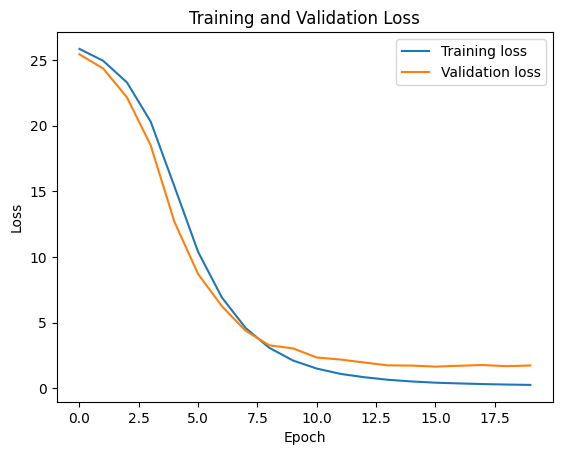

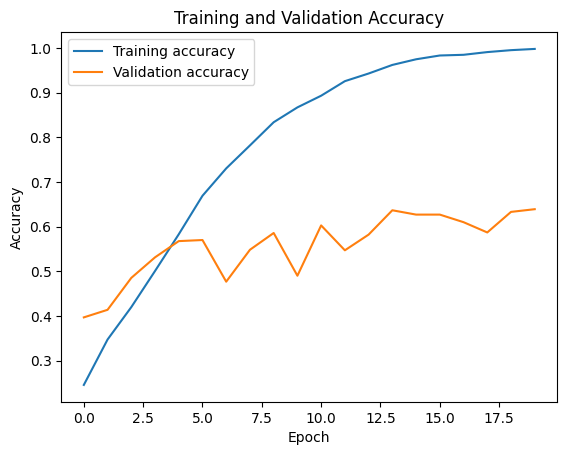

In [83]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 [==============================] - 0s 33ms/step
Confusion Matrix:


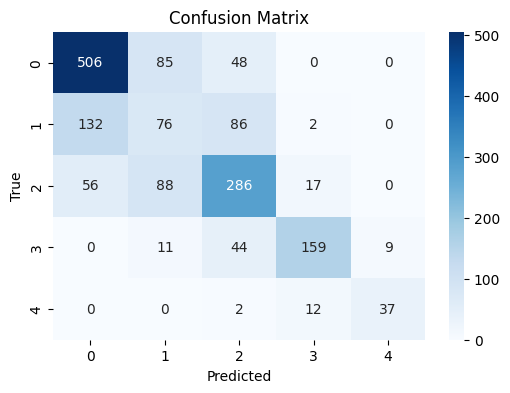


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       639
           1       0.29      0.26      0.27       296
           2       0.61      0.64      0.63       447
           3       0.84      0.71      0.77       223
           4       0.80      0.73      0.76        51

    accuracy                           0.64      1656
   macro avg       0.66      0.63      0.64      1656
weighted avg       0.64      0.64      0.64      1656



In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np


val_results = model.evaluate(test_dataset)

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    predictions = model.predict(x_val)
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


In [85]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 21 01:29:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    52W / 400W |  17737MiB / 40960MiB |     11%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------